In [1]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [768]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data = {self.data})"

    def __add__(self, other):
        # If other is just a number, wrap it in Value()
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
        
    def __radd__(self, other): # other + self
        return self + other

    
    def __mul__(self, other):
        # If other is just a number, wrap it in Value()
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other): # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1.0)) * out.grad
        out._backward = _backward
        return out
        
    def __neg__(self): # -self 
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)
    
    def __truediv__(self, other):
        # If other is just a number, wrap it in Value()
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data**-1, (self, other), '/')
        def _backward():
            self.grad += (other.data**-1) * out.grad
            other.grad += (self.data * -1.0 * other.data**-2) * out.grad
        out._backward = _backward
        return out

    def __rtruediv__(self, other): # other / self
        return other * (self**-1)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            
        # print(self.data)
        # self._backward()  
        # for child in self._prev:  
        #   child.backward()
        

In [729]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            #  and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

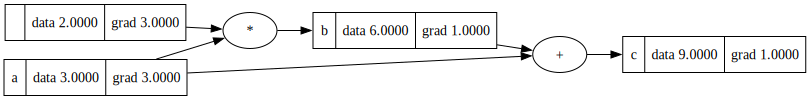

In [711]:
a = Value(3.0, label = 'a')
b = 2 * a; b.label = 'b'
c = a + b; c.label = 'c'
c.backward()
draw_dot(c)

9.0
3.0
6.0
3.0
2


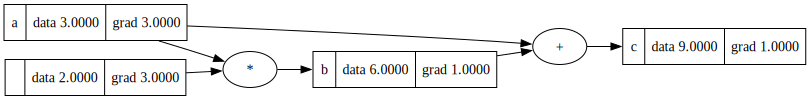

In [709]:
a = Value(3.0, label = 'a')
b = 2 * a; b.label = 'b'
c = a + b; c.label = 'c'
c.grad = 1.0
c.backward()
draw_dot(c)

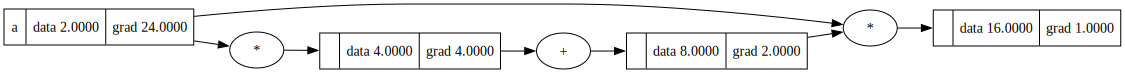

In [718]:
a = Value(2.0, label='a')
b = a * a        # b = a²
c = b + b        # c = 2b
d = c * a        # d = a * c
d.grad = 1.0
d.backward()
draw_dot(d)

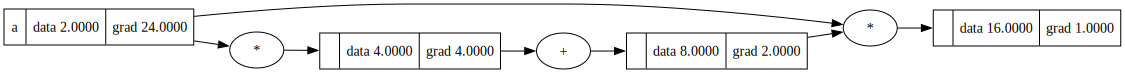

In [721]:
a = Value(2.0, label='a')
b = a * a        # b = a²
c = b + b        # c = 2b
d = c * a        # d = a * c
# d.grad = 1.0
d.backward()
draw_dot(d)

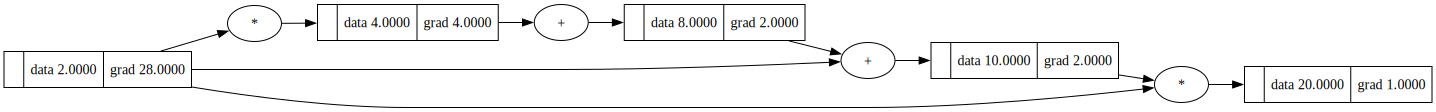

In [723]:
a = Value(2.0)
b = a * a
c = b + b
e = c + a      # new node
d = e * a
d.backward()
draw_dot(d)

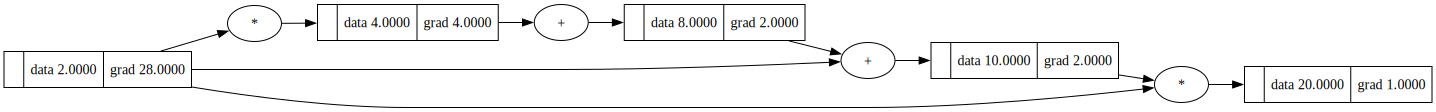

In [727]:
a = Value(2.0)
b = a * a
c = b + b
e = c + a      # new node
d = e * a
d.grad = 1.0
d.backward()
draw_dot(d)

In [294]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


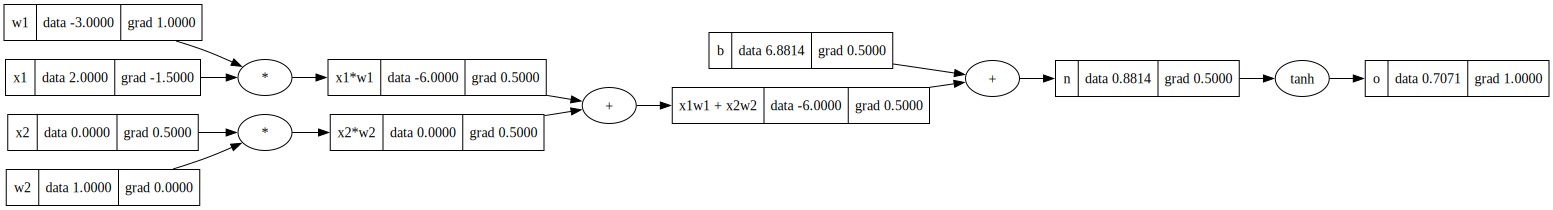

In [297]:
draw_dot(o)

In [296]:
o.backward()

# o.grad = 1.0; n.grad = 1 - o.data**2; b.grad = 1 - o.data**2;
# x1w1x2w2.grad = 1 - o.data**2;
# x2w2.grad = 1 - o.data**2;
# x1w1.grad = 1 - o.data**2;
# w1.grad = x1w1.grad * x1.data;
# x1.grad = x1w1.grad * w1.data;
# w2.grad = x2w2.grad * x2.data;
# x2.grad = x2w2.grad * w2.data;

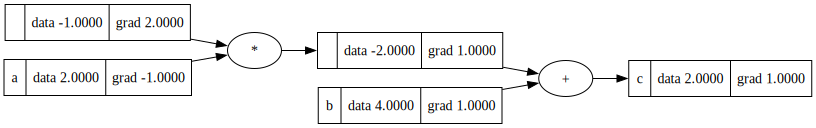

In [679]:
a = Value(2.0, label = 'a')
b = Value(4.0, label = 'b')
c = b - a; c.label = 'c'
c.backward()
draw_dot(c)

In [301]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# -----------
n2 = n * 2
o = (n2.exp() - 1) / (n2.exp() + 1)
# o = n.tanh(); 
# -----------
o.label = 'o'
o.backward()

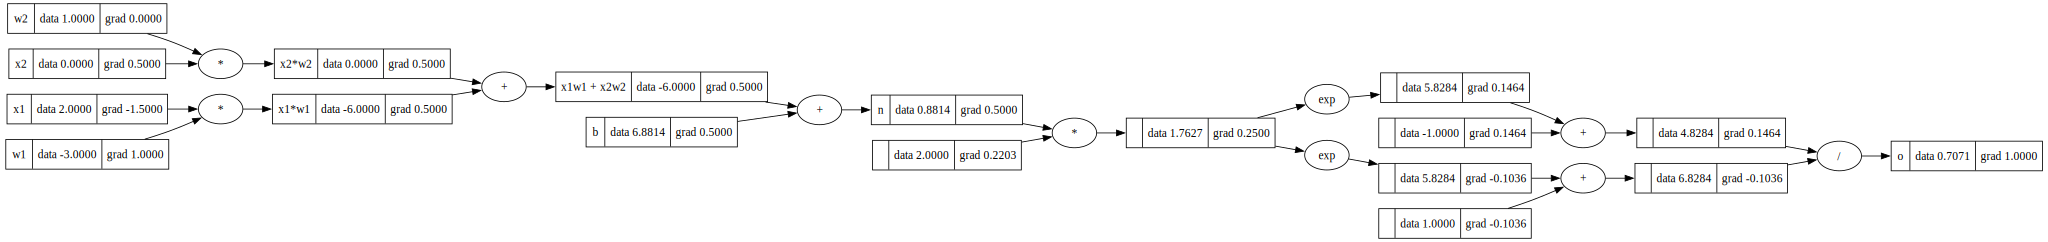

In [302]:
draw_dot(o)

In [308]:
import torch
import random

In [309]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                              ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()                ; b.requires_grad = True
n = x1*w1 + x2*w2 + b                                
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('------------')
print('x2', x2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
------------
x2 0.5000001283844369
x1 -1.5000003851533106
w1 1.0000002567688737
w2 0.0


In [310]:
o.item()

0.7071066904050358

In [730]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1,))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        # nin means how many weights for Neuron
        # nout means how many neurons for Current Layer
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    # MLP(nin, [hidden1, hidden2, ..., out])
    # nin means input dim
    # nouts means each layer how many neurons
    # attention: input layer no weights
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [775]:
random.seed(42)
n = MLP(3, [4, 4, 1])

In [776]:
xs = [
    [2.0, 3.0, -1.0], /   
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets, binary classification

In [777]:
for k in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    # loss.grad = 1.0 # we need this if we use recursively backward version
    loss.backward()

    # update
    for p in n.parameters():
        # if k < 6:
        p.data += -0.05 * p.grad
        # else:
            # p.data += -0.01 * p.grad
    params_dfs  = [p.data for p in n.parameters()]
    print(k, loss.data)

0 5.230517512042234
1 2.704689050764245
2 1.846023725231498
3 1.1774870087919076
4 0.8217294550832636
5 0.5957215587693913
6 0.43115794091632764
7 0.3468314917603137
8 0.28903713992681357
9 0.24605065583938188
10 0.213093898139367
11 0.18718814718937846
12 0.1663875535316572
13 0.149379973370315
14 0.1352548466184191
15 0.12336389545940175
16 0.1132349374106049
17 0.10451700918771248
18 0.0969444902613684
19 0.09031307448189843


In [773]:
ypred

[Value(data = 0.8990913680379728),
 Value(data = -0.9395396552244507),
 Value(data = -0.8776918229448193),
 Value(data = 0.9147590600819089)]

In [ ]:
# 1. calcualte loss
# 2. backward update weights's grad
# 3. update weights to make loss up/down